In [1]:
%load_ext rpy2.ipython
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler, \
    TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import cdist_dtw
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans

In [2]:
r.load('/Users/gonzalovidal/Gonzalo/Synthetic Biology/AI/gfpData.Rdata')

array(['gfpData'], dtype='<U7')

In [3]:
gfpdata = r['gfpData'] 
timecourses = gfpdata[1]
raw = timecourses[0]
loess = timecourses[1]
const_norm = timecourses[2]
prom_activity = timecourses[3]

#### Data preprocessing

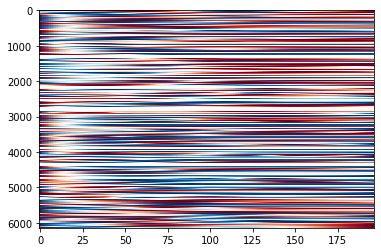

In [5]:
plt.imshow(prom_activity, aspect='auto', cmap='RdBu')

In [6]:
df_pa = pd.DataFrame(prom_activity)
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Columns: 197 entries, 0 to 196
dtypes: float64(197)
memory usage: 9.2 MB


In [7]:
df_pa.isna().sum()

0      1038
1      1038
2      1038
3      1038
4      1038
       ... 
192    1038
193    1038
194    1038
195    1038
196    1038
Length: 197, dtype: int64

In [8]:
laplace = df_pa.dropna(axis=0)
laplace

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,0.000000,0.056264,0.111195,0.164729,0.216802,0.267352,0.316316,0.363630,0.409231,0.453055,...,0.318557,0.314932,0.311317,0.307706,0.304091,0.300466,0.296825,0.293161,0.289468,0.285738
1,0.829623,0.846086,0.861820,0.876804,0.891015,0.904430,0.917027,0.928785,0.939680,0.949689,...,0.233682,0.232331,0.231286,0.230539,0.230083,0.229908,0.230006,0.230370,0.230990,0.231859
2,1.000000,0.971540,0.943509,0.915901,0.888710,0.861931,0.835559,0.809587,0.784009,0.758821,...,0.072469,0.073241,0.074110,0.075076,0.076138,0.077298,0.078554,0.079908,0.081358,0.082905
3,0.000000,0.050540,0.099978,0.148269,0.195366,0.241224,0.285797,0.329040,0.370907,0.411353,...,0.538748,0.539140,0.539576,0.540063,0.540603,0.541201,0.541862,0.542588,0.543385,0.544256
4,0.312508,0.350780,0.387973,0.424017,0.458839,0.492371,0.524540,0.555276,0.584508,0.612165,...,0.938671,0.944822,0.951114,0.957559,0.964167,0.970947,0.977910,0.985066,0.992426,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,1.000000,0.964438,0.929459,0.895088,0.861347,0.828263,0.795859,0.764159,0.733188,0.702969,...,0.003569,0.003141,0.002721,0.002309,0.001906,0.001511,0.001123,0.000742,0.000368,0.000000
6140,0.000000,0.027545,0.054399,0.080538,0.105936,0.130571,0.154416,0.177448,0.199642,0.220974,...,0.624511,0.608825,0.592850,0.576576,0.559993,0.543093,0.525866,0.508302,0.490391,0.472126
6141,1.000000,0.973293,0.946948,0.920973,0.895376,0.870165,0.845350,0.820937,0.796937,0.773356,...,0.002946,0.002580,0.002225,0.001880,0.001545,0.001219,0.000902,0.000594,0.000293,0.000000
6142,1.000000,0.984670,0.969445,0.954320,0.939289,0.924347,0.909489,0.894708,0.879999,0.865356,...,0.017674,0.015796,0.013899,0.011981,0.010042,0.008080,0.006096,0.004088,0.002057,0.000000


In [9]:
laplace = laplace.loc[~(laplace==0).all(axis=1)]
laplace

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
0,0.000000,0.056264,0.111195,0.164729,0.216802,0.267352,0.316316,0.363630,0.409231,0.453055,...,0.318557,0.314932,0.311317,0.307706,0.304091,0.300466,0.296825,0.293161,0.289468,0.285738
1,0.829623,0.846086,0.861820,0.876804,0.891015,0.904430,0.917027,0.928785,0.939680,0.949689,...,0.233682,0.232331,0.231286,0.230539,0.230083,0.229908,0.230006,0.230370,0.230990,0.231859
2,1.000000,0.971540,0.943509,0.915901,0.888710,0.861931,0.835559,0.809587,0.784009,0.758821,...,0.072469,0.073241,0.074110,0.075076,0.076138,0.077298,0.078554,0.079908,0.081358,0.082905
3,0.000000,0.050540,0.099978,0.148269,0.195366,0.241224,0.285797,0.329040,0.370907,0.411353,...,0.538748,0.539140,0.539576,0.540063,0.540603,0.541201,0.541862,0.542588,0.543385,0.544256
4,0.312508,0.350780,0.387973,0.424017,0.458839,0.492371,0.524540,0.555276,0.584508,0.612165,...,0.938671,0.944822,0.951114,0.957559,0.964167,0.970947,0.977910,0.985066,0.992426,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,1.000000,0.964438,0.929459,0.895088,0.861347,0.828263,0.795859,0.764159,0.733188,0.702969,...,0.003569,0.003141,0.002721,0.002309,0.001906,0.001511,0.001123,0.000742,0.000368,0.000000
6140,0.000000,0.027545,0.054399,0.080538,0.105936,0.130571,0.154416,0.177448,0.199642,0.220974,...,0.624511,0.608825,0.592850,0.576576,0.559993,0.543093,0.525866,0.508302,0.490391,0.472126
6141,1.000000,0.973293,0.946948,0.920973,0.895376,0.870165,0.845350,0.820937,0.796937,0.773356,...,0.002946,0.002580,0.002225,0.001880,0.001545,0.001219,0.000902,0.000594,0.000293,0.000000
6142,1.000000,0.984670,0.969445,0.954320,0.939289,0.924347,0.909489,0.894708,0.879999,0.865356,...,0.017674,0.015796,0.013899,0.011981,0.010042,0.008080,0.006096,0.004088,0.002057,0.000000


#### Select data

In [10]:
laplace.shape

(5106, 197)

In [11]:
np_pa = laplace.to_numpy()

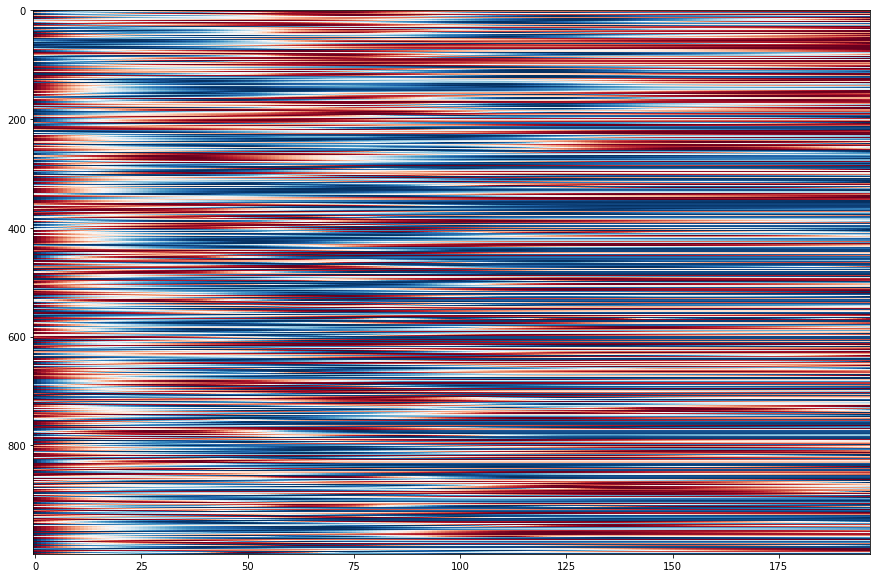

In [37]:
spa = np_pa[:1000]
spa.shape
plt.figure(figsize=(15,10))
plt.imshow(spa, aspect='auto', cmap='RdBu')
#print(np.isnan(spa))


#### Transform into timeseries type

(1000, 197, 1)
(0,)
(0,)


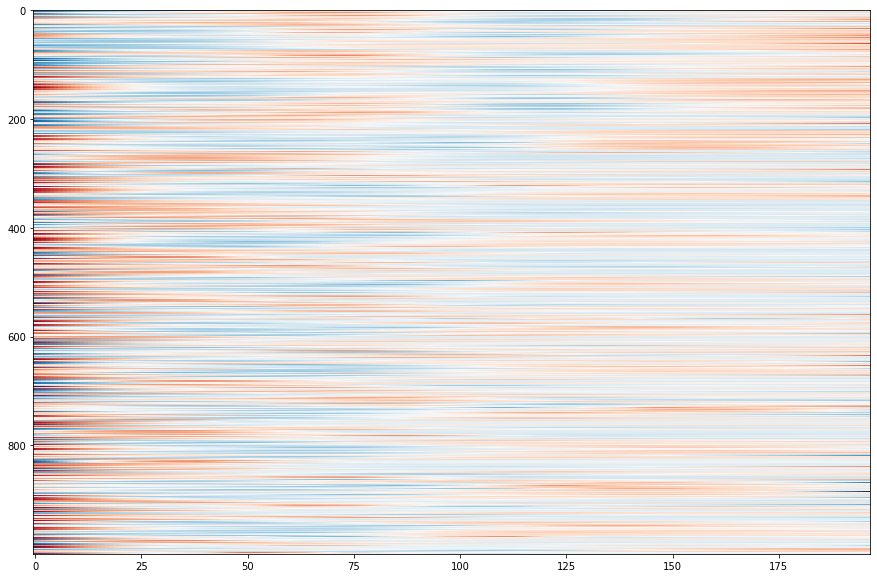

In [41]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(spa)
#plt.plot(X_train[:,:,0], '-');
print(X_train.shape)
print(X_train[np.isnan(X_train)].shape)
print(X_train[X_train==-np.inf].shape)
#Should be consistent with your selected data and have a 1 in the end
plt.figure(figsize=(15,10))
plt.imshow(X_train[:,:,0], aspect='auto', cmap='RdBu')

#### Clusterization metrics

Euclidean k-means 2
Euclidean k-means 3
Euclidean k-means 4
Euclidean k-means 5
Euclidean k-means 6
Euclidean k-means 7
Euclidean k-means 8
Euclidean k-means 9
Euclidean k-means 10
Euclidean k-means 11
Euclidean k-means 12
Euclidean k-means 13
Euclidean k-means 14
Euclidean k-means 15
CPU times: user 3min 17s, sys: 711 ms, total: 3min 18s
Wall time: 57.8 s


Clusters      15.000000
Silhouette     0.241431
Inertia       32.242620
Name: 13, dtype: float64

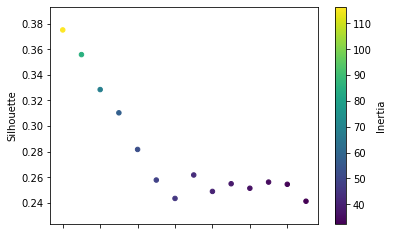

In [17]:
%%time
sz = X_train.shape[1]
seed = 0
lclusters = []
lsilscore = []
linertia = []
max_clusters = 15

for clu in range(2,max_clusters+1):
    nc = clu
    np.random.seed(seed)
    # Euclidean k-means
    print("Euclidean k-means" , clu)
    km = TimeSeriesKMeans(n_clusters=nc, random_state=seed, n_init=10)
    y_pred = km.fit_predict(X_train)
    silscore = silhouette_score(X_train, y_pred, metric="euclidean")
    iner = km.inertia_
    lclusters.append(nc)
    lsilscore.append(silscore)
    linertia.append(iner)
    
cluq = {'Clusters': lclusters, 'Silhouette':lsilscore, 'Inertia':linertia}
pd_cluq = pd.DataFrame(cluq)
pd_cluq.plot.scatter(x='Clusters',
                      y='Silhouette',
                      c='Inertia',
                      colormap='viridis');
minsil = pd_cluq['Silhouette'].idxmin()
pd_cluq.iloc[minsil,:]

#### Use the best k to cluster

In [26]:
%%time
nc = pd_cluq['Clusters'].iloc[7] #this should be a parameter obtained from the previous part .iloc[minsil]
sz = X_train.shape[1]
seed = 0
np.random.seed(seed)
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=nc, verbose=True, random_state=seed, n_init=10)
y_pred = km.fit_predict(X_train)

Euclidean k-means
Init 1
56.283 --> 44.991 --> 44.272 --> 43.936 --> 43.664 --> 43.494 --> 43.453 --> 43.412 --> 43.373 --> 43.342 --> 43.294 --> 43.243 --> 43.199 --> 43.182 --> 43.169 --> 43.165 --> 43.161 --> 43.151 --> 43.139 --> 43.130 --> 43.129 --> 43.129 --> 
Init 2
57.910 --> 45.055 --> 43.847 --> 43.606 --> 43.528 --> 43.501 --> 43.495 --> 43.494 --> 43.494 --> 
Init 3
57.646 --> 47.196 --> 45.657 --> 44.833 --> 44.482 --> 44.148 --> 43.945 --> 43.853 --> 43.810 --> 43.777 --> 43.753 --> 43.732 --> 43.717 --> 43.713 --> 43.713 --> 43.713 --> 
Init 4
57.138 --> 47.653 --> 46.978 --> 46.607 --> 46.286 --> 45.984 --> 45.382 --> 44.730 --> 44.361 --> 44.214 --> 44.170 --> 44.140 --> 44.122 --> 44.117 --> 44.105 --> 44.099 --> 44.049 --> 43.952 --> 43.820 --> 43.782 --> 43.771 --> 43.754 --> 43.738 --> 43.712 --> 43.684 --> 43.644 --> 43.589 --> 43.538 --> 43.512 --> 43.483 --> 43.461 --> 43.427 --> 43.415 --> 43.415 --> 
Init 5
59.453 --> 46.712 --> 45.790 --> 45.148 --> 44.619 -

#### Plot your clusters

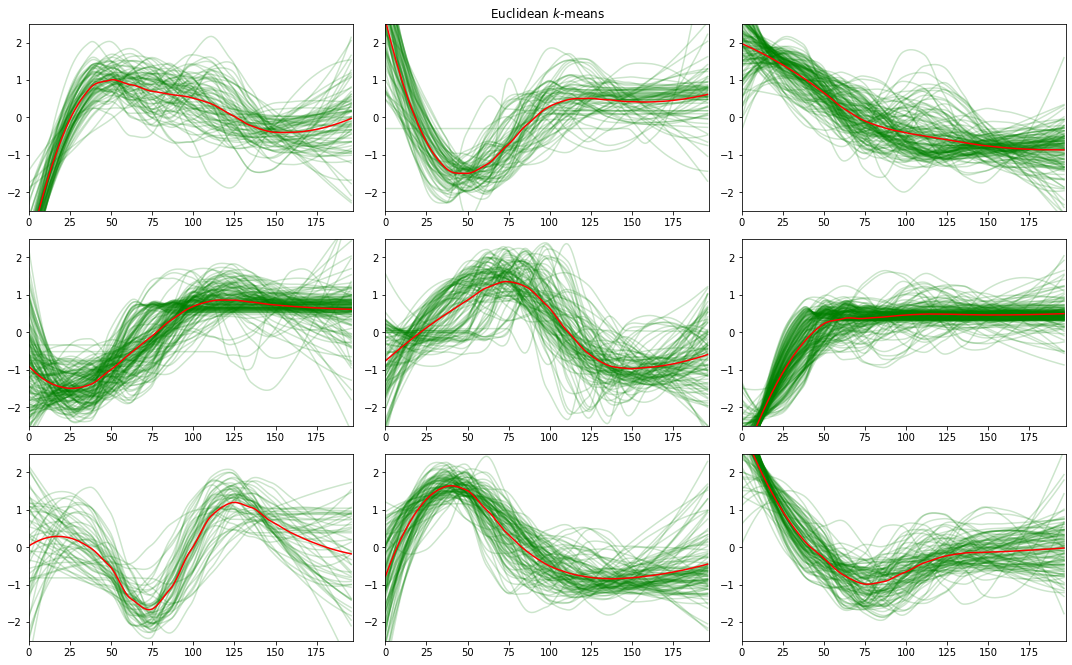

In [27]:
plt.figure(figsize=[15,30])
for yi in range(nc):
    plt.subplot(10, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "g-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-2.5, 2.5)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.tight_layout()
plt.savefig('kmclustering.png')
plt.show()

#### Save the model

In [28]:
from joblib import dump, load

In [29]:
dump(km, 'model_kmeans9_genex.joblib')

['model_kmeans9_genex.joblib']

In [30]:
kmodel = load('model_kmeans9_genex.joblib')
kmodel.predict(X_train)


array([7, 6, 8, 0, 6, 6, 1, 8, 8, 2, 6, 3, 7, 2, 3, 6, 3, 6, 1, 3, 1, 4,
       3, 3, 3, 3, 8, 6, 3, 3, 7, 2, 2, 8, 2, 6, 2, 2, 8, 2, 7, 6, 6, 2,
       2, 3, 0, 5, 0, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 8, 2, 8, 2,
       3, 2, 2, 7, 2, 2, 4, 8, 1, 8, 8, 6, 3, 3, 6, 6, 3, 6, 2, 2, 1, 1,
       1, 8, 8, 2, 8, 2, 2, 6, 8, 8, 8, 6, 1, 2, 8, 0, 7, 5, 7, 2, 6, 6,
       1, 3, 5, 3, 3, 4, 2, 6, 8, 5, 3, 6, 5, 0, 5, 7, 2, 2, 0, 7, 0, 7,
       5, 2, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 7, 5, 7,
       0, 0, 2, 7, 2, 2, 6, 5, 3, 2, 4, 2, 7, 6, 8, 6, 8, 6, 3, 3, 1, 6,
       3, 3, 3, 2, 6, 6, 1, 6, 1, 8, 8, 8, 6, 7, 8, 6, 8, 3, 5, 3, 1, 3,
       1, 8, 7, 1, 4, 1, 8, 3, 3, 1, 2, 2, 2, 1, 8, 3, 3, 3, 6, 3, 1, 3,
       8, 2, 2, 2, 7, 7, 4, 2, 4, 4, 0, 5, 0, 0, 4, 4, 0, 5, 0, 4, 0, 7,
       2, 4, 0, 0, 0, 2, 4, 4, 4, 3, 4, 5, 4, 0, 4, 1, 5, 8, 1, 7, 3, 1,
       1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 5, 3, 3, 5, 5, 5, 2,
       8, 5, 1, 5, 1, 3, 8, 4, 7, 7, 2, 8, 1, 5, 1,

In [50]:
y_pred # These arrays should be the same

array([7, 6, 8, 0, 6, 6, 1, 8, 8, 2, 6, 3, 7, 2, 3, 6, 3, 6, 1, 3, 1, 4,
       3, 3, 3, 3, 8, 6, 3, 3, 7, 2, 2, 8, 2, 6, 2, 2, 8, 2, 7, 6, 6, 2,
       2, 3, 0, 5, 0, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 8, 2, 8, 2,
       3, 2, 2, 7, 2, 2, 4, 8, 1, 8, 8, 6, 3, 3, 6, 6, 3, 6, 2, 2, 1, 1,
       1, 8, 8, 2, 8, 2, 2, 6, 8, 8, 8, 6, 1, 2, 8, 0, 7, 5, 7, 2, 6, 6,
       1, 3, 5, 3, 3, 4, 2, 6, 8, 5, 3, 6, 5, 0, 5, 7, 2, 2, 0, 7, 0, 7,
       5, 2, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 7, 5, 7,
       0, 0, 2, 7, 2, 2, 6, 5, 3, 2, 4, 2, 7, 6, 8, 6, 8, 6, 3, 3, 1, 6,
       3, 3, 3, 2, 6, 6, 1, 6, 1, 8, 8, 8, 6, 7, 8, 6, 8, 3, 5, 3, 1, 3,
       1, 8, 7, 1, 4, 1, 8, 3, 3, 1, 2, 2, 2, 1, 8, 3, 3, 3, 6, 3, 1, 3,
       8, 2, 2, 2, 7, 7, 4, 2, 4, 4, 0, 5, 0, 0, 4, 4, 0, 5, 0, 4, 0, 7,
       2, 4, 0, 0, 0, 2, 4, 4, 4, 3, 4, 5, 4, 0, 4, 1, 5, 8, 1, 7, 3, 1,
       1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 5, 3, 3, 5, 5, 5, 2,
       8, 5, 1, 5, 1, 3, 8, 4, 7, 7, 2, 8, 1, 5, 1,

#### Done! now lets get information from the clusters

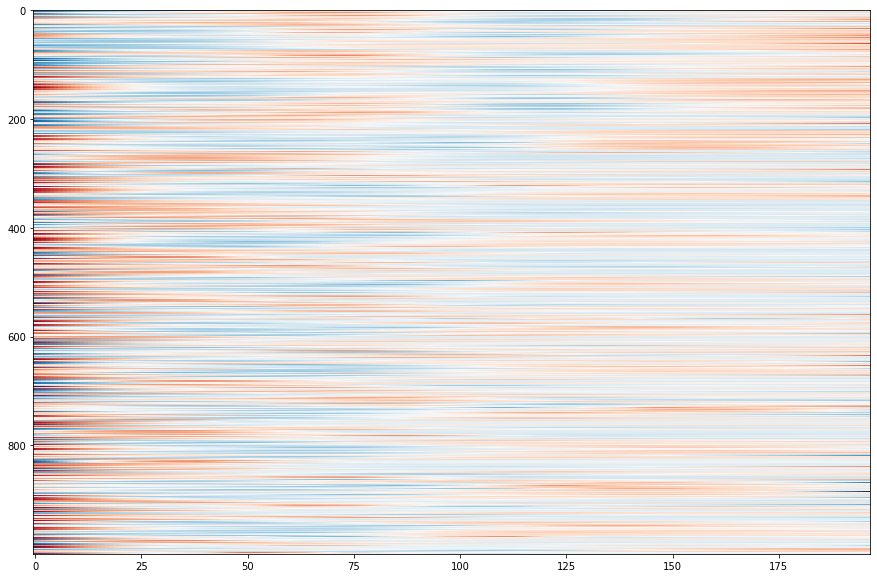

In [42]:
plt.figure(figsize=(15,10))
plt.imshow(X_train[:,:,0], aspect='auto', cmap='RdBu') #order this according to the labels the patterns should appear

In [43]:
#order the heatmap acording to the labels

In [53]:
jarvan = laplace[:1000].copy()
jarvan['labels'] = y_pred
jarvan

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,labels
0,0.000000,0.056264,0.111195,0.164729,0.216802,0.267352,0.316316,0.363630,0.409231,0.453055,...,0.314932,0.311317,0.307706,0.304091,0.300466,0.296825,0.293161,0.289468,0.285738,7
1,0.829623,0.846086,0.861820,0.876804,0.891015,0.904430,0.917027,0.928785,0.939680,0.949689,...,0.232331,0.231286,0.230539,0.230083,0.229908,0.230006,0.230370,0.230990,0.231859,6
2,1.000000,0.971540,0.943509,0.915901,0.888710,0.861931,0.835559,0.809587,0.784009,0.758821,...,0.073241,0.074110,0.075076,0.076138,0.077298,0.078554,0.079908,0.081358,0.082905,8
3,0.000000,0.050540,0.099978,0.148269,0.195366,0.241224,0.285797,0.329040,0.370907,0.411353,...,0.539140,0.539576,0.540063,0.540603,0.541201,0.541862,0.542588,0.543385,0.544256,0
4,0.312508,0.350780,0.387973,0.424017,0.458839,0.492371,0.524540,0.555276,0.584508,0.612165,...,0.944822,0.951114,0.957559,0.964167,0.970947,0.977910,0.985066,0.992426,1.000000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,0.000000,0.036481,0.072351,0.107588,0.142173,0.176085,0.209304,0.241809,0.273580,0.304597,...,0.150366,0.151620,0.152955,0.154381,0.155910,0.157554,0.159323,0.161228,0.163281,4
1157,0.000000,0.025691,0.051014,0.075994,0.100657,0.125030,0.149137,0.173006,0.196663,0.220132,...,0.966422,0.966422,0.966422,0.966422,0.966422,0.966422,0.966422,0.966422,0.966422,5
1158,1.000000,0.991199,0.982735,0.974425,0.966089,0.957547,0.948618,0.939120,0.928874,0.917698,...,0.570189,0.570189,0.570189,0.570189,0.570189,0.570189,0.570189,0.570189,0.570189,1
1159,0.000000,0.003097,0.006489,0.010158,0.014088,0.018260,0.022658,0.027265,0.032064,0.037037,...,0.942595,0.942595,0.942595,0.942595,0.942595,0.942595,0.942595,0.942595,0.942595,3


In [57]:
demacia = jarvan.sort_values(['labels'])
demacia

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,labels
155,0.000000,0.040965,0.081166,0.120574,0.159160,0.196897,0.233755,0.269706,0.304721,0.338772,...,0.503204,0.506084,0.509172,0.512473,0.515990,0.519727,0.523688,0.527876,0.532296,0
142,0.000000,0.045737,0.090527,0.134346,0.177168,0.218969,0.259724,0.299407,0.337995,0.375461,...,0.777913,0.786613,0.795517,0.804638,0.813988,0.823579,0.833423,0.843533,0.853920,0
143,0.000000,0.045729,0.090553,0.134437,0.177348,0.219250,0.260110,0.299892,0.338562,0.376087,...,0.870375,0.876693,0.883159,0.889783,0.896573,0.903536,0.910680,0.918013,0.925544,0
144,0.000000,0.042052,0.083258,0.123604,0.163073,0.201652,0.239323,0.276073,0.311886,0.346747,...,0.669112,0.677397,0.685933,0.694737,0.703824,0.713213,0.722919,0.732960,0.743352,0
1127,0.000000,0.030173,0.059854,0.089050,0.117768,0.146015,0.173798,0.201124,0.227999,0.254432,...,0.519538,0.522518,0.525554,0.528647,0.531800,0.535011,0.538284,0.541618,0.545016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,1.000000,0.961107,0.922879,0.885343,0.848523,0.812447,0.777140,0.742628,0.708939,0.676097,...,0.028498,0.028925,0.029394,0.029907,0.030465,0.031067,0.031714,0.032408,0.033149,8
187,1.000000,0.996177,0.992085,0.987741,0.983162,0.978365,0.973366,0.968183,0.962833,0.957333,...,0.157599,0.159383,0.161443,0.163772,0.166366,0.169218,0.172325,0.175680,0.179278,8
188,1.000000,0.978346,0.956928,0.935758,0.914845,0.894201,0.873837,0.853764,0.833991,0.814531,...,0.014795,0.012742,0.010760,0.008844,0.006985,0.005179,0.003417,0.001693,0.000000,8
363,1.000000,0.966485,0.933508,0.901087,0.869240,0.837983,0.807335,0.777313,0.747935,0.719218,...,0.122842,0.123474,0.124090,0.124690,0.125272,0.125837,0.126384,0.126912,0.127421,8


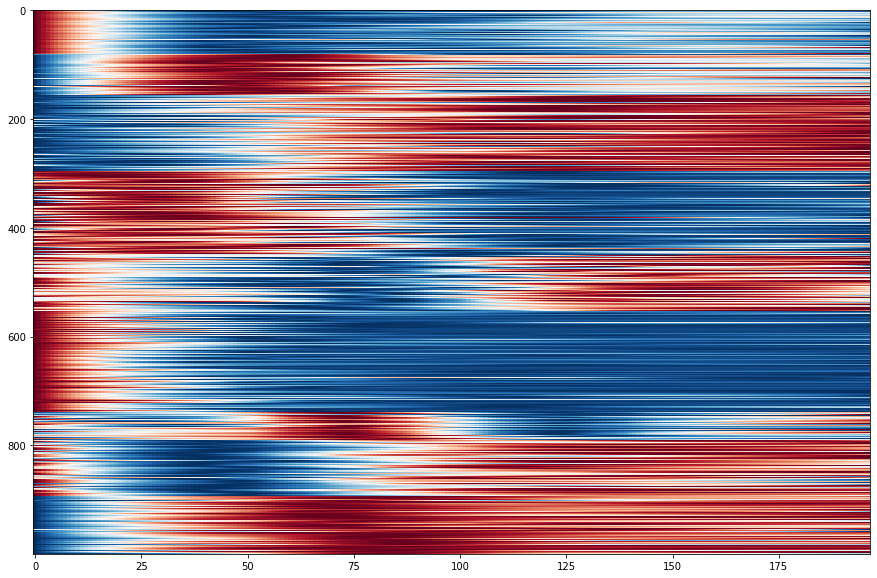

In [61]:
np_demacia = demacia.to_numpy()
plt.figure(figsize=(15,10))
plt.imshow(np_demacia[:,:-1], aspect='auto', cmap='RdBu')